In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# 簡単なLSTM
LSTMモデルを用いてsin波に対して学習・予測を行う.

## データの生成

データセットを作成する. 時系列データの場合, テーブルデータの手法(Hold-out, K-fold検証)のようにランダムにデータを分割することはできない. そこで, 訓練データをインデックス0～24に対してラベルをインデックス25のデータにする, インデックス1～25に対してラベルをインデックス26のデータにするというように先読みが発生しないようにデータセットを作成する.

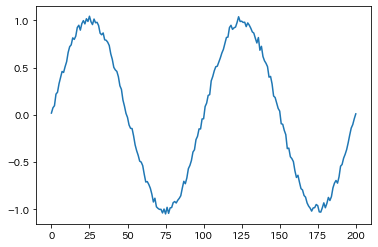

In [2]:
def sin(x,T=100):
    # T : 周期
    return np.sin(2.0*np.pi*x/T)

def add_noise(T=100,ampl=0.05):
    # ノイズを付加する関数
    x=np.arange(0,2*T+1)
    noise = ampl*np.random.uniform(low=-1.0,high=1.0,size=len(x))
    return sin(x)+noise

f = add_noise()
f[:5]

plt.figure(facecolor="white")
plt.plot(f)
plt.show()

In [3]:
def make_dataset(low_data,n_prev=100):
    data,target=[],[]
    # 25個を1つの時系列として分割
    maxlen=25
    # [i:i+25]のtrainにi+25+1のtargetを対応させる
    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i+maxlen])
        target.append(low_data[i+maxlen])
    
    re_data = np.array(data).reshape(len(data),maxlen,1)
    re_target = np.array(target).reshape(len(data),1)
    
    return re_data,re_target

x_train,y_train = make_dataset(f)

In [4]:
x_train.shape,y_train.shape

((176, 25, 1), (176, 1))

## モデリング

In [6]:
len_of_sequence = x_train.shape[1]
in_out_neurons = 1
n_hidden = 300

model = Sequential()
model.add(LSTM(n_hidden,batch_input_shape=(None,len_of_sequence,in_out_neurons),return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error",optimizer=optimizer)

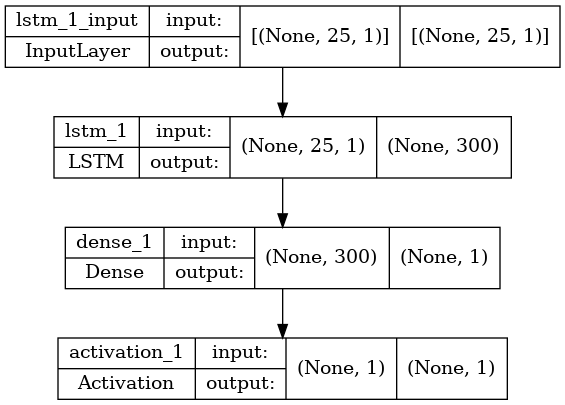

In [7]:
# モデルを画像として出力
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True,to_file='LSTM-sample.png')

In [8]:
early_stopping = EarlyStopping(monitor="val_loss",mode="auto",patience=20)
history = model.fit(x_train,y_train,
         batch_size=300,
         epochs=100,
         validation_split=0.1,
         callbacks=[early_stopping])

Epoch 1/100


2022-03-23 21:18:21.710077: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


1/1 [==============================] - 3s 3s/step - loss: 0.5566 - val_loss: 0.1298
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 0.3401 - val_loss: 0.0403
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.1860 - val_loss: 0.1275
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1272 - val_loss: 0.2612
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1322 - val_loss: 0.1824
Epoch 6/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0854 - val_loss: 0.0846
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0506 - val_loss: 0.0361
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0421 - val_loss: 0.0189
Epoch 9/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0435 - val_loss: 0.0138
Epoch 10/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0438 - val_loss: 0.0120
Epoch 11/100
1/1 [===============

In [9]:
def plot_loss(history):
    """エポックごとの損失関数をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    # 損失関数の履歴を取得
    loss_train = history.history["loss"]
    loss_val = history.history["val_loss"]

    # 損失関数をプロット
    epochs=range(1,len(history.history["loss"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs,loss_train,label="Training loss")
    plt.plot(epochs,loss_val,label="Validation loss")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

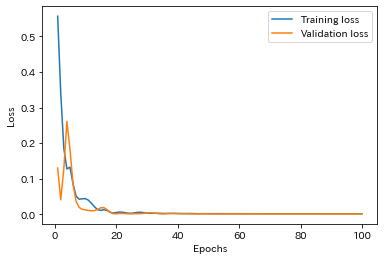

In [10]:
# 損失関数の描画
plot_loss(history)

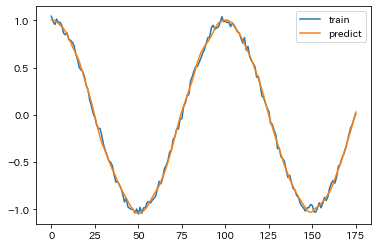

In [12]:
# 予測
predict = model.predict(x_train)

plt.figure(facecolor="white")
plt.plot(y_train,label="train")
plt.plot(predict,label="predict")
plt.legend()
plt.show()

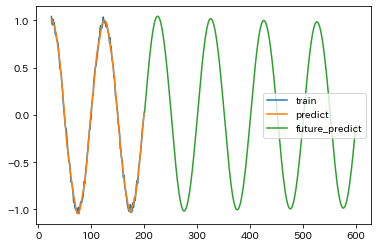

In [62]:
# 将来予測
future_test = x_train[-1] # 最初の25個のデータ
time_length = future_test.shape[0]
# 未来の予測を保存する
future_result = np.empty(0)

for step in range(400):
    test_data = np.reshape(future_test, (1, time_length, 1)) # テストデータを(1,25,1)にする
    batch_predict = model.predict(test_data)
    future_test = np.delete(future_test,0) # 先頭のデータを削除
    future_test = np.append(future_test, batch_predict) # 予測したデータを末尾に追加
    future_result = np.append(future_result,batch_predict)

plt.figure(facecolor="white")
plt.plot(range(25,len(predict)+25),y_train,label="train")
plt.plot(range(25,len(predict)+25),predict,label="predict")
plt.plot(range(len(f), len(future_result)+len(f)),future_result,label="future_predict")
plt.legend()
plt.show()